In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]
import sys

True
using device: cuda


In [2]:
sys.path.append("models/")
from mcg_ae import AE, compute_loss, train_step

In [3]:
# read in original and base imputation data
adata = sc.read_h5ad("mcg_210505_4798x819_qc.h5ad")
zdata = sc.read_h5ad("mcg_210505_4798x819_zero_imputation.h5ad")
mdata = sc.read_h5ad("mcg_210505_4798x819_mean_imputation.h5ad")
kdata = sc.read_h5ad("mcg_210505_4798x819_knn_imputation.h5ad")

cell_type = pd.read_csv("/u/project/cluo/heffel/BICAN3/Annotate/metadata_09122025.csv.gz").set_index("ID")

## Hyperparameters

In [4]:
xdata = zdata # set xdata to the base imputation method data to push through autoencoder

In [5]:
ldim = 32
hdim = ldim * 2

## Train Model

In [6]:
X = xdata.to_df().astype("float32")
X = torch.tensor(X.values).to(device) # convert to tensors so readable to computer during training

# initialize model & optimizer
model = AE(input_dim=X.shape[1], hidden_dim=hdim, latent_dim=ldim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# load data into batches
from torch.utils.data import Dataset, DataLoader

class AutoencoderDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index].to(device)
    
dataset = AutoencoderDataset(X)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [8]:
%%time

epochs = 1000
loss_hist = []
no_improve_counter = 0
patience = 20
min_decrease = 0.000001
best_loss = float("inf")

# training loop
for epoch in range(epochs):
    epoch_loss = 0.0
 
    for data in dataloader:
        loss = train_step(model, data, optimizer)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    loss_hist.append(avg_epoch_loss)
    
    if avg_epoch_loss < best_loss - min_decrease:
        best_loss = avg_epoch_loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        
    if no_improve_counter >= patience:
        print(f"early stopping at epoch {epoch + 1}, avg loss: {avg_epoch_loss:.6f}")
        break
        
    if epoch % 100 == 0:
        print(f"epoch {epoch + 1}, avg loss: {avg_epoch_loss:.6f}")

epoch 1, avg loss: 0.074208
epoch 101, avg loss: 0.052981
epoch 201, avg loss: 0.052705
early stopping at epoch 213, avg loss: 0.052691
CPU times: user 12.6 s, sys: 200 ms, total: 12.8 s
Wall time: 12.8 s


## Generate Data

In [9]:
ae_imp = pd.DataFrame(model.inference(X.to(device)).detach().cpu().numpy(), index=adata.to_df().index, columns=adata.to_df().columns)
ae_imp.head(2)

geneslop2k,PRKCZ,ENSG00000157933.11,PRDM16,ENSG00000162591.17,AJAP1,NPHP4,ENSG00000097021.21,ENSG00000171735.20,ENSG00000142599.20,CASZ1,...,EFCAB6,PARVB,PRR5-ARHGAP8,PHF21B,CELSR1,GRAMD4,TBC1D22A,ENSG00000224271.8,TAFA5,ENSG00000188511.14
20210505-UMB5577-preAb-PFC-A09-L1_A1,0.292157,0.218354,0.198767,0.084210,0.112212,0.150816,0.043509,0.173368,0.114568,0.107335,...,0.147976,0.160332,0.192809,0.153130,0.168248,0.207401,0.132104,0.073350,0.215236,0.181993
20210505-UMB5577-preAb-PFC-A09-L1_A10,-0.085122,0.043942,0.042785,0.082205,-0.030584,-0.047384,-0.001596,0.061971,0.053314,0.081246,...,0.075828,0.079094,0.067545,0.120329,0.083677,0.019962,0.041553,0.042275,0.030442,-0.006850


In [10]:
# create AnnData object of generated data
aedata = ad.AnnData(X=ae_imp)
aedata.obs = adata.obs.copy()
aedata.var = adata.var.copy()

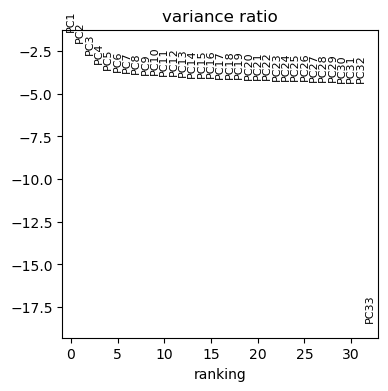

In [11]:
# pca
sc.tl.pca(aedata)
sc.pl.pca_variance_ratio(aedata, n_pcs=32, log=True)

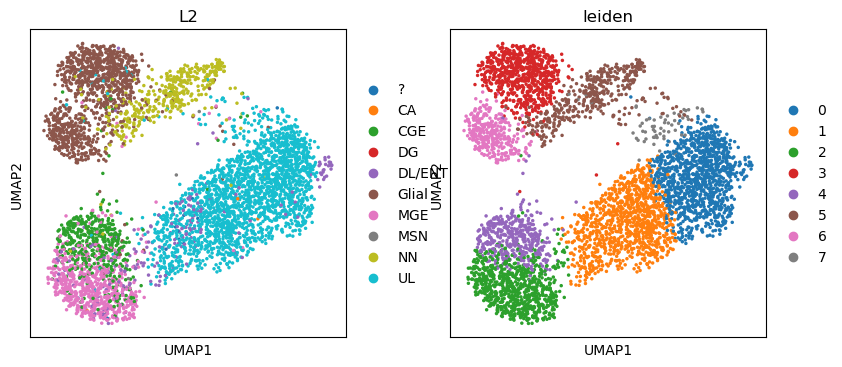

In [12]:
# umap
sc.pp.neighbors(aedata)
sc.tl.leiden(aedata)
sc.tl.umap(aedata)

aedata.obs["L2"] = cell_type["newL2"]
sc.pl.umap(aedata, color=["L2", "leiden"])

In [13]:
if xdata.to_df().equals(zdata.to_df()) == True:
    aedata.write_h5ad("mcg_210505_5618x670_autoencoder_zero_imputation.h5ad")
elif xdata.to_df().equals(mdata.to_df()) == True:
    aedata.write_h5ad("mcg_210505_5618x670_autoencoder_mean_imputation.h5ad")
else:
    aedata.write_h5ad("mcg_210505_5618x670_autoencoder_knn_imputation.h5ad")